# Review Sentiment Analysis – Random Forest

EDA focused on rule-based ensembles and their interpretability for Beyond
Flavours restaurant reviews.

In [23]:
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(context="talk", style="whitegrid")


In [24]:
DATA_PATH = Path("..") / "data" / "raw" / "restaurant_reviews.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Standardise sentiment labels and engineer lexical metrics
Mirror the shared preprocessing so downstream models remain comparable across
notebooks.

In [25]:
def map_rating_to_label(rating: float) -> Literal["good", "bad"]:
    """Return the coarse sentiment bucket for a numeric rating.


    Ratings of 4.0 and above are marked 'very good', between 3.0 and 4.0 are

    treated as 'bad' (lukewarm), and anything below 3.0 is considered

    'horrible' per the project specification.

    """

    if rating > 3.0:
        return "good"
    return "bad"



df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

df["Review"] = df["Review"].fillna("").str.strip()

df = df.dropna(subset=["Rating"])

df = df[df["Review"] != ""].copy()

df["sentiment"] = df["Rating"].apply(map_rating_to_label)

df["review_length"] = df["Review"].str.len()

df["word_count"] = df["Review"].str.split().str.len()

df[["Rating", "sentiment", "review_length", "word_count"]].head()


,Rating,sentiment,review_length,word_count
0,5.0,good,222,41
1,5.0,good,144,27
2,5.0,good,189,31
3,5.0,good,148,28
4,5.0,good,160,27


## Sentiment proportions and lexical spread
Tree-based ensembles thrive on clear class splits; inspect the degree of
imbalance and spread in review verbosity.

In [26]:
summary = (
    df.groupby("sentiment")["word_count"].agg(["count", "median", "mean", "std"])
)
summary


,count,median,mean,std
sentiment,,,,
bad,3639,36.0,51.447925,56.321224
good,6315,33.0,49.438797,63.209604


C:\Users\kavin\AppData\Local\Temp\ipykernel_13720\229861552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", order=order, ax=axes[0], palette="crest")


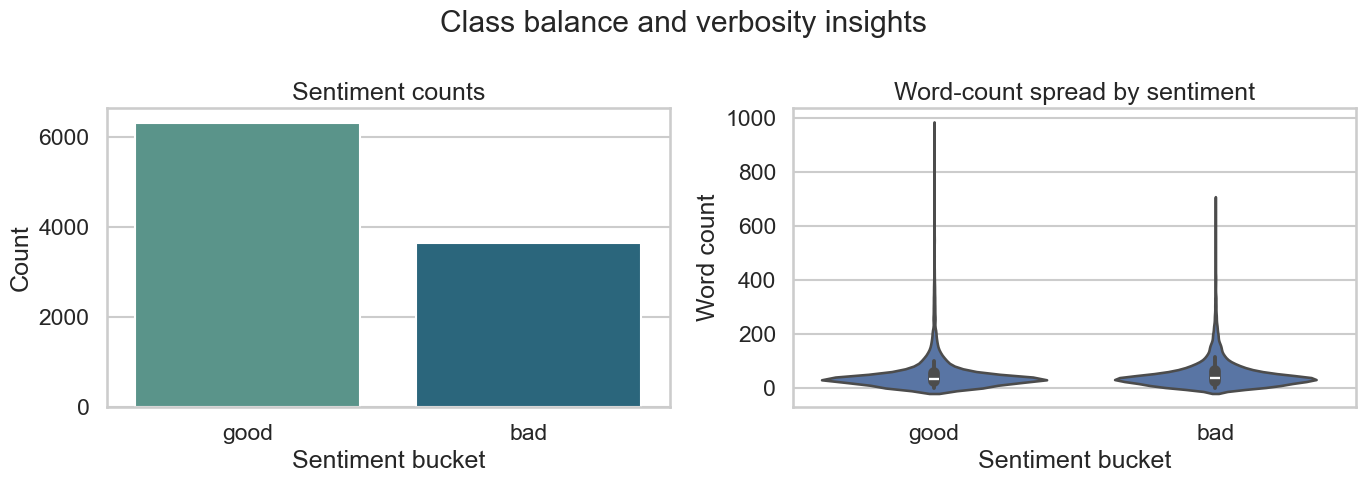

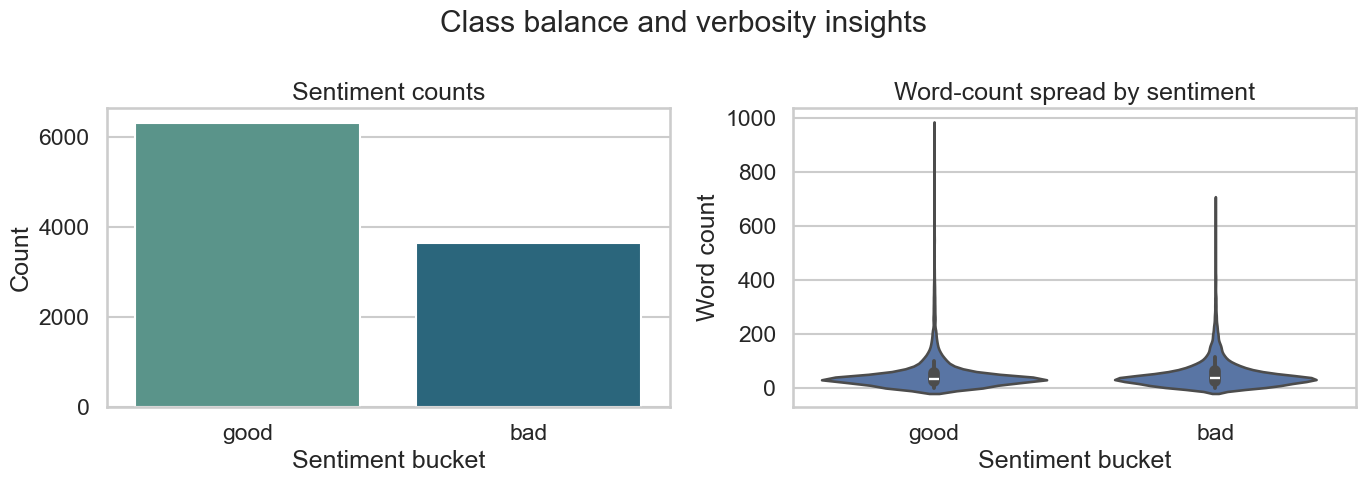

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
order = ["good", "bad"]
sns.countplot(data=df, x="sentiment", order=order, ax=axes[0], palette="crest")
axes[0].set_title("Sentiment counts")
axes[0].set_xlabel("Sentiment bucket")
axes[0].set_ylabel("Count")
sns.violinplot(data=df, x="sentiment", y="word_count", order=order, ax=axes[1])
axes[1].set_title("Word-count spread by sentiment")
axes[1].set_xlabel("Sentiment bucket")
axes[1].set_ylabel("Word count")
fig.suptitle("Class balance and verbosity insights")
fig.tight_layout()
fig


## Random forest training and evaluation

Fit a balanced random forest with capped TF-IDF features to avoid an explosive feature space.


In [28]:
label_counts = df["sentiment"].value_counts()
stratify_labels = df["sentiment"] if label_counts.min() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    df["Review"],
    df["sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels,
)

rf_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=750)),
        ("model", RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )),
    ]
)
rf_pipeline.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [29]:
y_pred = rf_pipeline.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)
print(report)


              precision    recall  f1-score   support

         bad       0.87      0.79      0.83       728
        good       0.89      0.93      0.91      1263

    accuracy                           0.88      1991
   macro avg       0.88      0.86      0.87      1991
weighted avg       0.88      0.88      0.88      1991



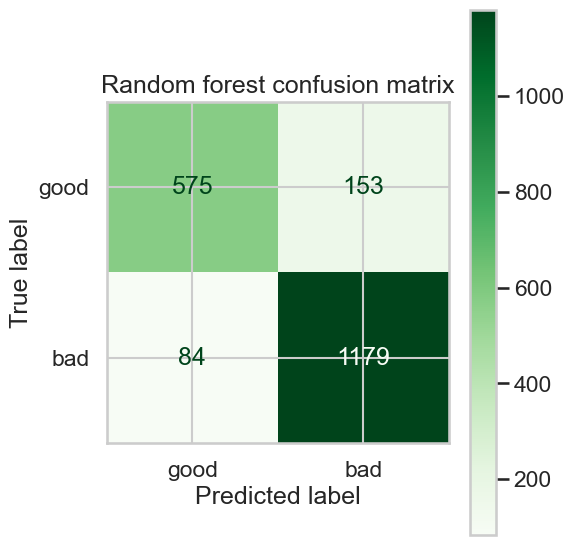

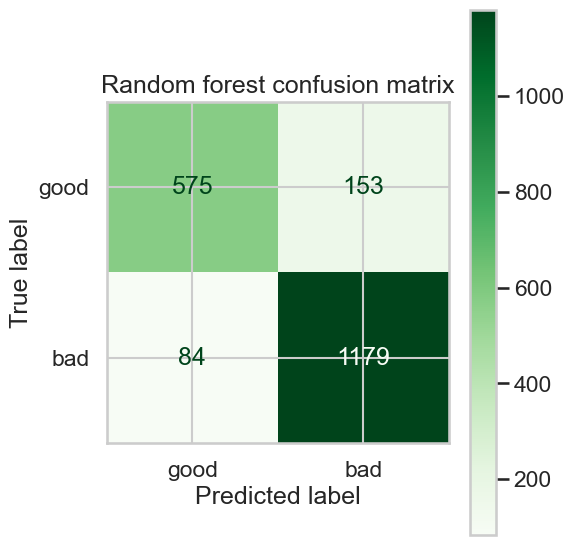

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    rf_pipeline,
    X_test,
    y_test,
    display_labels=["good", "bad"],
    cmap="Greens",
    values_format="d",
    ax=ax,
)
ax.set_title("Random forest confusion matrix")
fig.tight_layout()
fig


## Feature importance signals

Highlight the n-grams that trees consider most informative for splitting sentiment classes.


In [31]:
vectorizer = rf_pipeline.named_steps["tfidf"]
model = rf_pipeline.named_steps["model"]
feature_names = vectorizer.get_feature_names_out()
importances = pd.Series(model.feature_importances_, index=feature_names)
top_importances = importances.sort_values(ascending=False).head(20)
top_importances


not          0.062739
good         0.033027
worst        0.025053
bad          0.024102
awesome      0.020700
best         0.018284
great        0.015817
amazing      0.015344
nice         0.014550
but          0.013068
ordered      0.011696
and          0.010521
must         0.010428
the best     0.010281
no           0.010141
love         0.010139
was not      0.009675
place        0.009431
delicious    0.009196
excellent    0.008896
dtype: float64

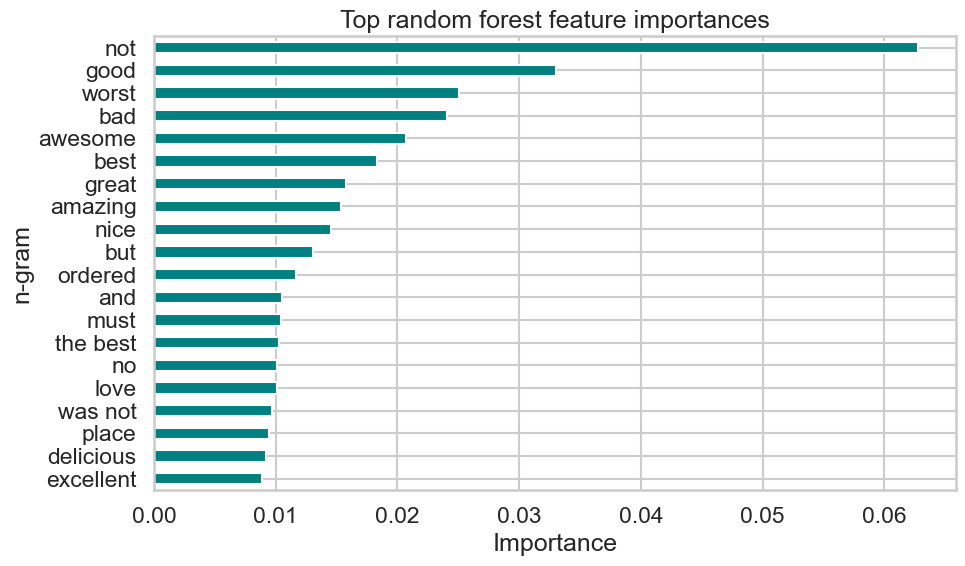

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
top_importances.sort_values().plot.barh(ax=ax, color="teal")
ax.set_title("Top random forest feature importances")
ax.set_xlabel("Importance")
ax.set_ylabel("n-gram")
fig.tight_layout()
